In [22]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from collections import Counter
import pandas as pd
import warnings
import json
import os

# Allow python to import modules from the preprocessing folder
sys.path.append("src/preprocessing/")
warnings.filterwarnings("ignore") # For seaborn

from load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [23]:
years = range(1960, 2012)
movies_df = load_movies_df()

In [24]:
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

In [25]:
groupped = movies_df.groupby("movie_release_year").sum().reset_index()
groupped = groupped.loc[(groupped["movie_release_year"] > 1960) & (groupped["movie_release_year"] < 2012)]

In [26]:
GDP_PATH = "data/gdp/gdp_data.csv"
gdp_df = pd.read_csv(GDP_PATH)

In [27]:
iceland_gdp = gdp_df[gdp_df["Country Name"] == "Iceland"]

gdp_list = []
for year in years:
    gdp_list.append(iceland_gdp[str(year)].iloc[0])
    
iceland_gdp = pd.DataFrame.from_dict({"year" : years, "iceland_gdp" : gdp_list})

In [28]:
groupped = groupped.merge(iceland_gdp, left_on="movie_release_year", right_on="year")
groupped = groupped.rename(columns={"box_office" : "Box-office", "iceland_gdp" : "Iceland GDP"})
groupped = groupped.drop(columns=["wiki_movie_id", "movie_runtime", "movie_release_year"])

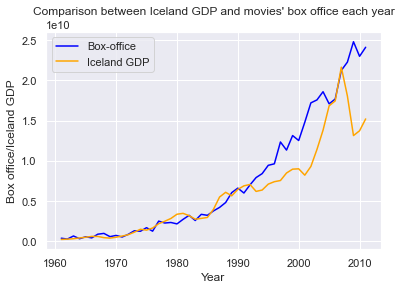

In [40]:
sns.set_theme()
sns.lineplot(data=pd.melt(groupped, ["year"]), x="year", y="value", hue="variable", palette={"Box-office" : "blue", "Iceland GDP" : "orange"})
plt.title("Comparison between Iceland GDP and movies' box office each year")
plt.legend()
plt.ylabel("Box office/Iceland GDP")
plt.xlabel("Year")
plt.show()